In [1]:
import io
import os
import re
import sys
import math
import glob
import pandas_bokeh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import bokeh
from venn import venn

def read_vcf(path):
  """
  This function reads a .vcf file and stores it as a df.
  
  Required Argument: path to .vcf file
  
  Returns: Dataframe
  """
  with open(path, 'r') as f:
      lines = [l for l in f if not l.startswith('##')]
  return pd.read_csv(
      io.StringIO(''.join(lines)),
      dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
             'QUAL': str, 'FILTER': str, 'INFO': str},
      sep='\t'
  ).rename(columns={'#CHROM': 'CHROM'})
pd.set_option('display.max_rows', 130)

def roundup(x):
  """
  This function rounds up a number to the first higher 200-fold
  
  Argument: Float or Int
  
  Returns 200-fold int
  """
  return int(math.ceil(x / 200.0)) * 200

def histAF(AFcolumn, tool):
    return AFcolumn.plot_bokeh(
                    kind="hist",
                    bins=np.linspace(0, 1, 101),
                    histogram_type="sidebyside",
                    vertical_xlabel=True,
                    hovertool=True,
                    title="Allele Frequency " + sample,
                    ylabel = '# Of mutations',
                    xlabel = 'Mean Allele Frequency per mutation, calculated by '+tool,
                    legend = None,
                    line_color="black",
                    show_figure = False)

def histAF2(AFcolumn, tool):
    return AFcolumn.plot_bokeh(
                    kind="hist",
                    color='darkblue',
                    bins=np.linspace(0, 0.1, 51),
                    histogram_type="sidebyside",
                    vertical_xlabel=True,
                    hovertool=True,
                    title="Allele Frequency " + sample,
                    ylabel = '# Of mutations',
                    xlabel = 'Mean Allele Frequency per mutation, calculated by '+tool+', Zoomed in on 0 - 0.01',
                    legend = None,
                    line_color="black",
                    show_figure = False)

def histDP(DPcolumn, tool):
    return DPcolumn.plot_bokeh(
                    kind="hist",
                    color='green',
                    bins=np.linspace(0, roundup(DPcolumn.max()), int(roundup(DPcolumn.max())/200+1)),
                    histogram_type="sidebyside",
                    vertical_xlabel=True,
                    hovertool=True,
                    title='Read Depth '+ sample,
                    ylabel = '# Of mutations',
                    xlabel = 'Read Depth per mutation, calculated by '+tool,
                    legend = None,
                    line_color="black",
                    show_figure = False)

def dfMutect(path, sample, tool):
    #Stripped Mutect2 output:
    dfm2 = read_vcf(path+tool+'/'+sample+'_PoN-decomposed-normalized.vcf')
    dfm2['DP'] = dfm2['INFO'].str.split('DP=', 1).str[1].str.strip().str.split(';', 1).str[0].str.strip().astype(int)
    dfm2['AF'] = dfm2[dfm2.columns[9]].str.split(':', 1).str[1].str.strip().str.split(':', 1).str[1].str.strip().str.split(':', 1).str[0].str.strip().astype(float)
    dfm2['MUT'] = dfm2['CHROM'] + '_' + dfm2['POS'].astype(str)+'_' + dfm2['REF'] +'>' + dfm2['ALT']
    dfm2 = dfm2.drop(columns =['REF', 'ALT', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'])
    dfm2 = dfm2.drop(dfm2.columns[2], axis=1)
    return dfm2
    
def dfLofreq(path, sample, tool):
    #Stripped LoFreq output
    dflf = read_vcf(path+tool+'/'+sample+'_PoN-decomposed-normalized.vcf')
    dflf['DP'] = dflf['INFO'].str.split('DP=', 1).str[1].str.strip().str.split(';', 1).str[0].str.strip().astype(int)
    dflf['AF'] = dflf['INFO'].str.split('AF=', 1).str[1].str.strip().str.split(';', 1).str[0].str.strip().astype(float)
    dflf['MUT'] = dflf['CHROM'] + '_' + dflf['POS'].astype(str)+'_' + dflf['REF'] +'>' + dflf['ALT']
    dflf = dflf.drop(columns =['REF', 'ALT', 'ID','QUAL', 'FILTER', 'INFO'])
    return dflf

def dfVardict(path, sample, tool):
    #Stripped VarDict output
    dfvd = read_vcf(path+tool+'/'+sample+'_PoN-decomposed-normalized.vcf')
    dfvd['DP'] = dfvd['INFO'].str.split('DP=', 1).str[1].str.strip().str.split(';', 1).str[0].str.strip().astype(int)
    dfvd['AF'] = dfvd['INFO'].str.split('AF=', 1).str[1].str.strip().str.split(';', 1).str[0].str.strip().astype(float)
    dfvd['MUT'] = dfvd['CHROM'] + '_' + dfvd['POS'].astype(str)+'_' + dfvd['REF'] +'>' + dfvd['ALT']
    dfvd = dfvd.drop(columns =['REF', 'ALT', 'ID', 'FILTER', 'QUAL', 'INFO'])
    return dfvd

def dfSinvict(path, sample, tool):
    dfsv = read_vcf(path+tool+'/'+sample+'_PoN-decomposed-normalized.vcf')
    dfsv = dfsv.drop(columns =['ID', 'QUAL', 'FILTER', 'INFO'])
    dfsv['MUT'] = dfsv['CHROM'] + '_' + dfsv['POS'].astype(str)+'_' + dfsv['REF'] +'>' + dfsv['ALT']
    return dfsv

def plotDP_AF(path, sample, tool):

    pandas_bokeh.output_file(path + tool + "/"+ sample + " Read_Depth_&_AF_per_Mutation_.html")  

    if tool == 'Mutect2':
        dfm2 = dfMutect(path, sample, tool)
        pandas_bokeh.plot_grid([[histAF(dfm2['AF'], tool)], [histDP(dfm2['DP'], tool)], [histAF2(dfm2['AF'], tool)], [histDP(dfm2[dfm2['AF'] < 0.1]['DP'], tool)]], width=1500, height=440)
        print(dfm2, tool)

    elif tool == 'Lofreq':
        dflf = dfLofreq(path, sample, tool)
        pandas_bokeh.plot_grid([[histAF(dflf['AF'], tool)], [histDP(dflf['DP'], tool)], [histAF2(dflf['AF'], tool)], [histDP(dflf[dflf['AF'] < 0.1]['DP'], tool)]], width=1500, height=440)
        print(dflf, tool)

    elif tool == 'Vardict':
        dfvd = dfVardict(path, sample, tool)
        pandas_bokeh.plot_grid([[histAF(dfvd['AF'], tool)], [histDP(dfvd['DP'], tool)], [histAF2(dfvd['AF'], tool)], [histDP(dfvd[dfvd['AF'] < 0.1]['DP'], tool)]], width=1500, height=440)
        print(dfvd, tool)

    elif tool == 'Sinvict':
        dfsv = dfSinvict(path, sample, tool)
        print(dfsv, tool)
    else: 
        print('wrong tool')
        
def Vennplot_persample(sample):
    SNVcalls = {
    "SiNVICT": {i for i in dfSinvict(path, sample, 'Sinvict')['MUT']},
    "Mutect2": {i for i in dfMutect(path, sample, 'Mutect2')['MUT']},
    "LoFreq": {i for i in dfLofreq(path, sample, 'Lofreq')['MUT']},
    "VarDict": {i for i in dfVardict(path, sample, 'Vardict')['MUT']}
    }

    fig = venn(SNVcalls
         #, fmt="{percentage:.1f}%"
        ).figure
    fig.suptitle(sample + "  ", fontsize=15)
    plt.xlabel('# Of mutations found in control sample per tool: ', fontsize=12)
    #fig.savefig('/Lymphoma research/SNV & Translocations in ctDNA from DLBCL (Nick)/1. SNVs in ctDNA/Data/PoN analysis/per tool/' + sample +'_venn.png')   # save the figure to file
    plt.close(fig) 
    return fig

# ===============================================

In [2]:
path = '/Lymphoma research/SNV & Translocations in ctDNA from DLBCL (Nick)/1. SNVs in ctDNA/Data/PoN analysis/per tool/Normals_'

sample = '003-003'

tool = 'Mutect2'

In [3]:
#plotDP_AF(path, sample, tool)
#Vennplot_persample(sample)

In [4]:
SVmut = dfSinvict(path, sample, 'Sinvict')['MUT']
M2mut = dfMutect(path, sample, 'Mutect2')['MUT']
VDmut = dfVardict(path, sample, 'Vardict')['MUT']
LFmut = dfLofreq(path, sample, 'Lofreq')['MUT']

df1 = pd.DataFrame({'Sinvict': SVmut, 'Mutect2': M2mut, 'Vardict': VDmut, 'Lofreq': LFmut})

# df2 = df1[~df1.Sinvict.isin(VDmut)]
# df3 = df2[~df2.Sinvict.isin(M2mut)]
# df4 = df3[~df3.Sinvict.isin(LFmut)]
# len(df4['Sinvict'].dropna())
SVunique = df1[~df1.Sinvict.isin(VDmut)][~df1[~df1.Sinvict.isin(VDmut)].Sinvict.isin(M2mut)][~df1[~df1.Sinvict.isin(VDmut)][~df1[~df1.Sinvict.isin(VDmut)].Sinvict.isin(M2mut)].Sinvict.isin(LFmut)]['Sinvict'].dropna()
M2unique = df1[~df1.Mutect2.isin(VDmut)][~df1[~df1.Mutect2.isin(VDmut)].Mutect2.isin(SVmut)][~df1[~df1.Mutect2.isin(VDmut)][~df1[~df1.Mutect2.isin(VDmut)].Mutect2.isin(SVmut)].Mutect2.isin(LFmut)]['Mutect2'].dropna()
LFunique = df1[~df1.Lofreq.isin(VDmut)][~df1[~df1.Lofreq.isin(VDmut)].Lofreq.isin(SVmut)][~df1[~df1.Lofreq.isin(VDmut)][~df1[~df1.Lofreq.isin(VDmut)].Lofreq.isin(SVmut)].Lofreq.isin(M2mut)]['Lofreq'].dropna()
VDunique = df1[~df1.Vardict.isin(SVmut)][~df1[~df1.Vardict.isin(SVmut)].Vardict.isin(M2mut)][~df1[~df1.Vardict.isin(SVmut)][~df1[~df1.Vardict.isin(SVmut)].Vardict.isin(M2mut)].Vardict.isin(LFmut)]['Vardict'].dropna()

uniquedf = pd.DataFrame({'Sinvict': [len(SVmut), len(SVunique)], 
              'Mutect2': [len(M2mut), len(M2unique)], 
              'Vardict': [len(VDmut), len(VDunique)], 
              'Lofreq': [len(LFmut), len(LFunique)]}, index = ['Total', 'Unique'])

In [78]:
def groupedbar(df, title):
    labels = [1,2,3,4,5,6,7]  #list(df.columns)
    totals = np.array(df.loc['Overlapping'])
    uniques = np.array(df.loc['Unique'])
    
    
    percentages = np.divide(uniques, uniques+totals)*100
    
    x = np.arange(len(labels))
    width = 0.35  
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, totals, width, label='Overlapping', log = True)
    rects2 = ax.bar(x + width/2, uniques, width, label='Unique', log = True)
    rects3 = ax.bar(x + width/2, np.divide(uniques,2), width, log = True, color='#ff7f0e')
    
    ax.set_ylabel('Number of Mutations (log)')
    ax.set_title(title)# +': Total- & Unique SNV Calls per tool')
    ax.set_xticks(x, labels, fontsize = 7)
    ax.legend(loc='center left')
    ax.bar_label(rects1, padding=0.1)
    ax.bar_label(rects2, padding=0.1)
    ax.bar_label(rects3, padding=0.1, fmt = '%.1f', labels = [str(round(i,1))+'%' for i in percentages], fontsize = 7, rotation = 90)
    return fig

#groupedbar(uniquecalls_per_sample('Mutect2', samples), 'Mutect2')    
#groupedbar(df, title)   

In [79]:
amount_of_tools = df1.melt().groupby('value').count().value_counts()
values = dict(amount_of_tools).values()
keys = [i[0] for i in list(dict(amount_of_tools))]    

def barchart(x,y):
    figbar = plt.figure()
    plt.bar(x, y, color='mediumaquamarine', log=True)
    for i, v in enumerate(y):
        plt.text(x[i] - 0.12, v + 2, str(v))
    plt.xticks(np.arange(0, 5, step=1))
    plt.title(sample +': Number of Tools that call a specific mutation', )
    plt.xlabel('Number of tools')
    plt.ylabel('Number of mutations called (log)')
    return figbar

In [80]:
from matplotlib.backends.backend_pdf import *
def tablefig(df):
    tabfig, ax =plt.subplots(figsize=(4,4))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')
    return tabfig

In [81]:
# with PdfPages('../Data/PoN analysis/per tool/'+sample+'.pdf') as pdf:
#    pdf.savefig(groupedbar(uniquedf, sample))
#    pdf.savefig(tablefig(uniquedf))
#    pdf.savefig(barchart(keys, values))
#    pdf.savefig(Vennplot_persample(sample))


In [82]:
samples = ["001-010", "001-011", "001-012", "001-015", "002-022", "003-002", "003-003"]

def uniquecalls_per_sample(tool, samples):
    if tool == 'Mutect2':
        df = pd.DataFrame([dfMutect(path, i, tool)['MUT'] for i in samples]).T
    elif tool == 'Lofreq':
        df = pd.DataFrame([dfLofreq(path, i, tool)['MUT'] for i in samples]).T
    elif tool == 'Vardict':
        df = pd.DataFrame([dfVardict(path, i, tool)['MUT'] for i in samples]).T
    elif tool == 'Sinvict':
        df = pd.DataFrame([dfSinvict(path, i, tool)['MUT'] for i in samples]).T
    else: 
        print('wrong tool')
        
    df.columns = samples
    uniques = [len(set(df[sample]).difference(set(df.drop(sample, axis = 1).values.ravel()))) for sample in samples]
    totals = [len(df[sample].dropna()) for sample in samples]
    overlapped = np.array(totals)-np.array(uniques)
    data = list(zip(overlapped, uniques))
    
    uniquesampledf = pd.DataFrame(index = ['Total', 'Unique'])
    for sample in samples:    
        uniquesampledf[sample] = [len(df[sample].dropna()), 
                                  len(set(df[sample]).difference(set(df.drop(sample, axis = 1).values.ravel())))]
        
    uniquesampledf2 = pd.DataFrame(data).T
    uniquesampledf2.columns = samples
    uniquesampledf2.index = ['Overlapping', 'Unique']
    return uniquesampledf2

uniquecalls_per_sample(tool, samples)

,001-010,001-011,001-012,001-015,002-022,003-002,003-003
Overlapping,112,138,141,149,156,142,157
Unique,18,16,22,31,48,26,19


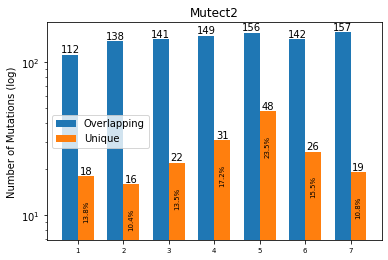

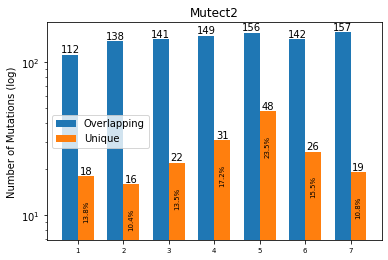

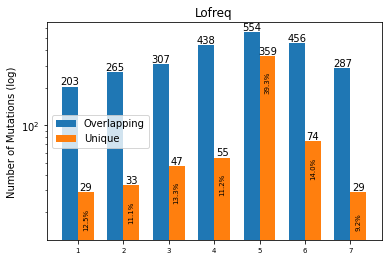

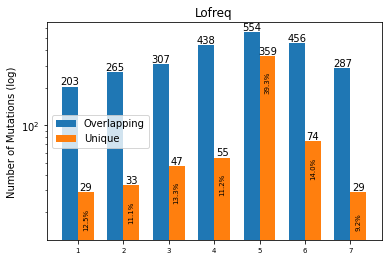

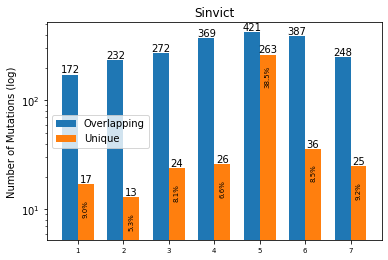

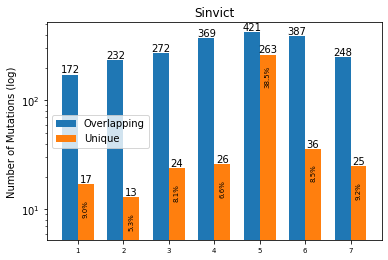

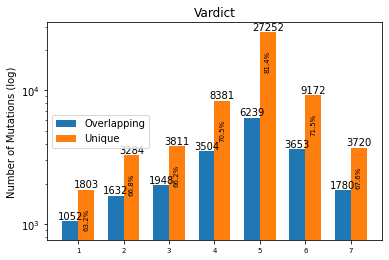

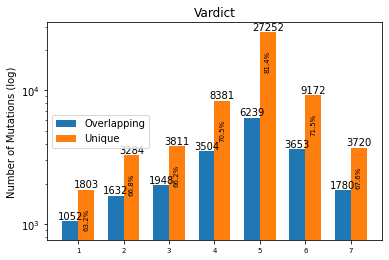

In [83]:
 with PdfPages('../Data/PoN analysis/per tool/Uniques_per_sample_Overlaps.pdf') as pdf:
     for x in ['Mutect2', 'Lofreq', 'Sinvict', 'Vardict']:
         pdf.savefig(groupedbar(uniquecalls_per_sample(x, samples), x))
         groupedbar(uniquecalls_per_sample(x, samples), x)
